In [2]:
from Depolarization_module import *
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

### Experimental determination of LED coherence function

First, we measure the depolarization of the LED source used in the experiment, through a variable liquid crystal retarder. The LED source is polarized circularlly, it propagates trought the variable retarder, and then, we measure the degree of polarization of the emergent beam as a function of the retarder's retardance

c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  encoding='latin1').mean(axis=None)
c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  encoding='latin1').mean(axis=None)
c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'fram

[ 9.41902084 25.08284134] [0.50750542 3.61700906]


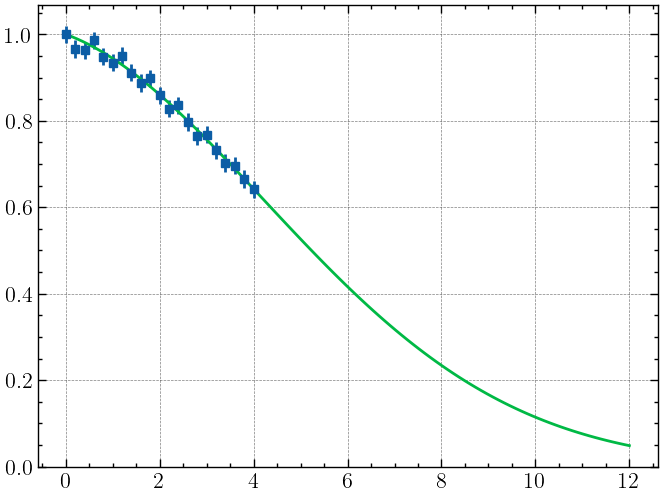

In [3]:
def gauss_lorentz(OptPathDiff, coh_gauss, coh_lorentz):

        func = np.exp(-(np.pi/2)*(OptPathDiff/coh_gauss)**2 -np.abs(OptPathDiff)/coh_lorentz
                      - (2j*OptPathDiff*np.pi/0.633))
        return np.abs(func)

LED_data = Polarimeter_data(path = "Data/LED coherence/")

LED_data_mean = LED_data.mean() #returns s1, s2, s3, alpha, chi, DOP mean values
LED_data_std = LED_data.std() #returns s1, s2, s3, alpha, chi, DOP std values

LED_dop = (LED_data_mean[:,5]-( LED_data_mean[:,5].max() - 100))/100  #returns the mean dop of each measurement
LED_dop_std = LED_data_std[:,5]/100 #returns the std of each dop measurement

retardance = np.linspace(0,4,len(LED_dop))  #retardance as optical path diference in um

plt.errorbar(retardance, LED_dop, yerr= 0.02, fmt ='s') #plot the data

x = np.linspace(0,12,100) #domain of the coherence function
popt, pcov = curve_fit(gauss_lorentz, retardance, LED_dop) #fit of the coherence function
coherence1 = Coherence.gauss_lorentz(x, list(popt), 0.633) #coherence function fitted

plt.plot(x, np.abs(coherence1)) #plot the fitted coherence function
print(popt, np.sqrt(np.diag(pcov)))


As we see in the result of the curve_fit module, the gauss-lorentz coherence function

$$ \gamma(\tau) = \exp\left\lbrace-\frac{i2\pi}{\lambda_0}x - \frac{\pi}{2}\left( \frac{x}{l_G} \right)^2 - \frac{|x|}{l_L}\right\rbrace, $$ 

 is a good match for the LED coherence function. The parameters associated with the LED are:
 
$$ l_G = 9.4 \pm 0.1 [\mu m],\qquad l_L = 25 \pm 4 [\mu m]. $$

Then, this will be the coherence function used for describe theoretically the depolarization of the LED in the biplate system.

Now, using the depolarization module we construct the biplate system and define the coherence function:

In [4]:
coherence = Coherence(coherence_func = 'GaussLorentz', coh_length = (9.4, 25), wavelength = 0.633)

Due to fast computation, instead of using the module we use a function with the exact expressions for the biplate system. The exact expressions for this system were calculated manually with the aid of sympy:

In [5]:
def biplate(theta, phi, OptPathDiff, coherence, init_state = []):
        
        """
        Parameters
        ----------
        theta : ROTATION ANGLE OF THE WAVEPLATE
        phi : ANGLE OF THE SECOND WAVEPLATE WITH RESPECT TO THE FIRST ONE
        OptPathDiff : OPTICAL PATH DIFFERENCE INTRODUCE BY THE RETARDER
        coherence: The coherence Function
        
        init_state : A list of the form [alpha, chi]
            alpha = ORIENTATION ANGLE OF THE INCIDENT POLARIZATION STATE.
            chi = ELIPTICITY ANGLE OF THE INCIDENT POLARIZATION STATE.
            
        Returns
        -------
        DOP, S1, S2, S3
        
        DOP : THE DEGREE OF POLARIZATION
        [S1, S2, S3] : THE TRANSFORMED STOKES PARAMETERS

        """
        
        alpha = np.deg2rad(init_state[0])
        chi = np.deg2rad(init_state[1])
        u = np.deg2rad(theta)
        phi = np.deg2rad(phi)
        
        E_x = np.cos(alpha)*np.cos(chi) - 1j*np.sin(alpha)*np.sin(chi)
        E_y = np.sin(alpha)*np.cos(chi) + 1j*np.cos(alpha)*np.sin(chi)
        
        #E_x = (1/np.sqrt(2))*(np.cos(chi) - np.sin(chi))*np.exp(1j*alpha)
        #E_y = (1/np.sqrt(2))*(np.cos(chi) + np.sin(chi))*np.exp(-1j*alpha)
        
        #Some constants
        A = (E_x*np.conjugate(E_y)) + (np.conjugate(E_x)*E_y)
        A1 = (E_x*np.conjugate(E_y)) - (np.conjugate(E_x)*E_y)
        B = E_x*np.conjugate(E_x) - E_y*np.conjugate(E_y)
        Jxy = E_x*np.conjugate(E_y)
        Jyx = np.conjugate(E_x)*E_y
        
        #Coherence functions
        Real1 = np.real(coherence.eval(OptPathDiff))
        Imag1 = np.imag(coherence.eval(OptPathDiff))
        Real2 = np.real(coherence.eval(2*OptPathDiff))
        Imag2 = np.imag(coherence.eval(2*OptPathDiff))
        
        # Elements of the final polarization matrix
        
        #Element J11 and J22
        J11_1 = ( 2*Real2 - 2 ) * ( A * ( np.sin(4*u + 4*phi) + np.sin(4*u) +  2*np.sin(4*u + 2*phi) ) + B * ( np.cos(4*u + 4*phi) + np.cos(4*u) +  2*np.cos(4*u + 2*phi) ) )
        J11_2 = ( 4j*Imag2 + 8j*Imag1 ) * ( A1 * ( np.sin(2*u + 2*phi) ) )
        J11_3 = 8j*Imag2 * A1 * np.sin(2*u) + ( 4j*Imag2 - 8j*Imag1 ) * ( A1* np.sin(2*u - 2*phi) ) 
        J11_4 = 2*Real2 * ( A * ( -np.sin(4*phi) - 2*np.sin(2*phi) ) + B * (-np.cos(4*phi) - 2*np.cos(2*phi) - 1 ) )
        J11_5 = 2*Real1 * ( A *4*np.sin(4*phi) + B * (4*np.cos(4*phi) - 4 ) )
        J11_6 = A*( -6*np.sin(4*phi) + 4*np.sin(2*phi) ) + B*( -6*np.cos(4*phi) + 4*np.cos(2*phi) ) - 10*E_y*np.conjugate(E_y) - 22*E_x*np.conjugate(E_x)
        
        J11 = -( J11_1 + J11_2 + J11_3 + J11_4 + J11_5 + J11_6 ) / 32
        
        
        J22 = 1 - J11
        
        #Element J12 and J21
        
        J12_1 = ( 2*Real2 - 2 ) * ( B*( -np.sin(4*u + 4*phi) - np.sin(4*u) -  2*np.sin(4*u + 2*phi) ) + A*( np.cos(4*u + 4*phi) + np.cos(4*u) +  2*np.cos(4*u + 2*phi) ) )
        J12_2 = ( 4j*Imag2 - 8j*Imag1 ) * ( B*( - np.sin(2*u + 4*phi)) + A*np.cos(2*u + 4*phi) + A1*np.cos(2*u - 2*phi) )
        J12_3 = (2j*Imag2*(6*Jxy + 2*Jyx) + 8j*Imag1*A1)*np.cos(2*u + 2*phi) - ( 4j*Imag2 + 8j*Imag1 )*B*np.sin(2*u)
        J12_4 = (2j*Imag2*(6*Jxy - 2*Jyx) + 8j*Imag1*A)*np.cos(2*u) - 8j*Imag2*B*np.sin(2*u + 2*phi)
        J12_5 = 2*Real2 * ( B*(-np.sin(4*phi) - 2*np.sin(2*phi)) + A*np.cos(4*phi) + (6*Jxy - 2*Jyx)*np.cos(2*phi) + 5*Jxy - 3*Jyx )
        J12_6 = 2*Real1 * ( 4*B*np.sin(4*phi) + A*(-4*np.cos(4*phi) + 4 ) )
        J12_7 = B*(-6*np.sin(4*phi) + 4*np.sin(2*phi)) + A*6*np.cos(4*phi) - (12*Jxy - 4*Jyx)*np.cos(2*phi) + 14*Jxy - 2*Jyx
        
        J12 = (J12_1 + J12_2 + J12_3 + J12_4 + J12_5 + J12_6 + J12_7)/32
        
        J21 = np.conjugate(J12)
        
        
        #calculate the DOP
        DOP = np.sqrt(1 - (4*(J11 * J22 - J12*J21)/(J11 + J22)**2))
        
        return np.real(DOP), np.real(J11 - J22), np.real(J12 + J21), np.real(1j*(J12 - J21))
   
def Graphic1(s1, s2, s3, path):
    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:30j]
    r = 1
    x = r* np.cos(u)*np.sin(v)
    y =  r* np.sin(u)*np.sin(v)
    z = r* np.cos(v)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Graficar la esfera
    ax.plot_wireframe(x, y, z, rstride=5, cstride=6, color='grey', alpha=0.3,
                      linewidth=1.3)
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='grey', alpha=0.2,
                    linewidth=0)
    
    #Graficar los ejes
    ax.plot([-1.1, 1.1], [0, 0], [0, 0], color='black', linewidth=1.5, alpha = 0.7)
    ax.plot([0, 0], [-1.1, 1.1], [0, 0], color='black', linewidth=1.5, alpha = 0.7)
    ax.plot([0, 0], [0, 0], [-1.1, 1.1], color='black', linewidth=1.5, alpha = 0.7)
    
    #Graphic some meridians for aesthetic
    theta = np.linspace(0, 2*np.pi, 100)
 
    xx = r * np.cos(theta)
    yy = r * np.sin(theta)
    zz = np.zeros_like(theta)
    ax.plot(xx, yy, zz, color='gray', linewidth=1.5, alpha = 1)
    ax.plot(yy, zz, xx, color='gray', linewidth=1.5, alpha = 1)

    # Graphic the Data on the Sphere

    ax.scatter(s1, s2, s3, color='red', alpha = 1, s=5)

    exp_data = Polarimeter_data(path = path)
    exp_s1 = exp_data.mean()[:,0]
    exp_s2 = exp_data.mean()[:,1]
    exp_s3 = exp_data.mean()[:,2]

    ax.scatter(exp_s1, exp_s2, exp_s3, color='blue', alpha = 1, s=30)
    
    #Configure the image
    fig.set_size_inches(9, 9)
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_zlim([-1.1, 1.1])
    ax.set_aspect("equal")
    ax.patch.set_alpha(0)
    plt.tight_layout()
    plt.axis('off')
    
    # Add the S_1 S_2 and S_3 names for the main axis of Poincaré Sphere
    ax.text(1.15, 0, 0, '$S_1$', fontsize=18)
    ax.text(0, 1.15, 0, '$S_2$', fontsize=18)
    ax.text(0, 0, 1.15, '$S_3$', fontsize=18)
        
    plt.show()

c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  encoding='latin1').mean(axis=None)
c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  encoding='latin1').mean(axis=None)
c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'fram

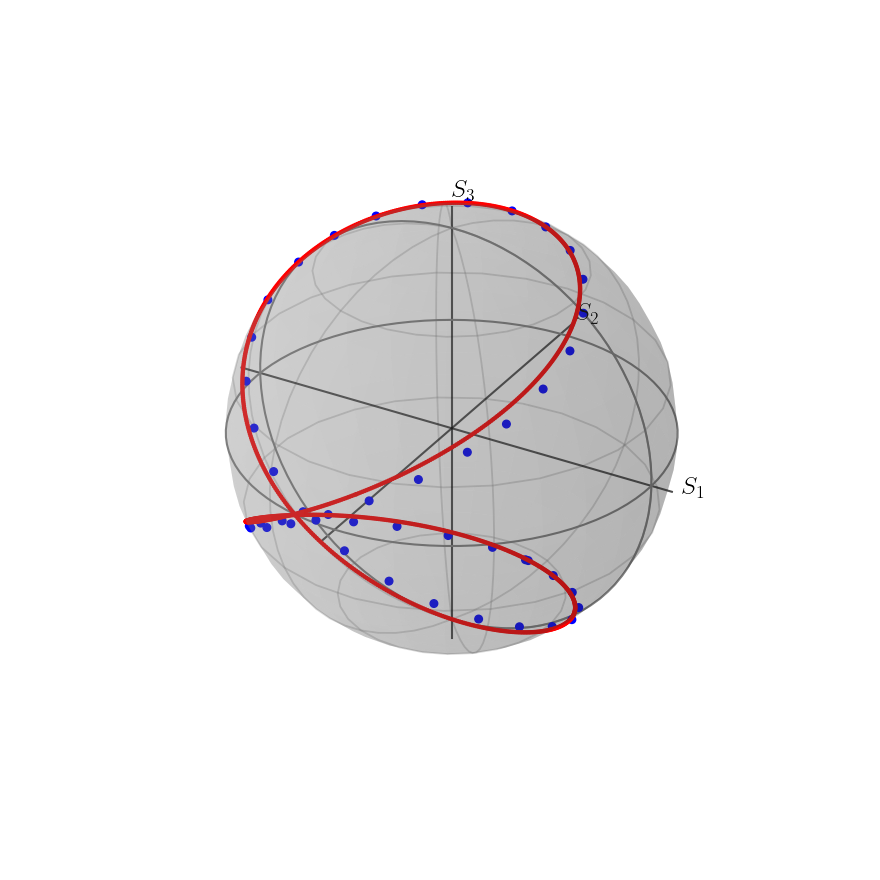

In [6]:

Optpathdiff = 38.995*0.633/4 #retardance of each waveplate in um
phi = -39 #angle between the waveplates
angle = np.linspace(0,180,1000) #rotation angle of the biplate

state1 = Polarimeter_data(path = 'Data/caracterization linear/').mean() #measured ellipticity of the incident linear state 
state2 = Polarimeter_data(path = 'Data/caracterization circular/').mean()#measured ellipticity  of the incident circular state 
state3 = Polarimeter_data(path = 'Data/caracterization elliptical/').mean() #measured ellipticity of the incident elliptical state 

DOP1, S1, S2, S3 = biplate(angle, phi, Optpathdiff, coherence, (0, state1[0][4]))

Graphic1(S1/DOP1, S2/DOP1, S3/DOP1, 'Data/linear/')

c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  encoding='latin1').mean(axis=None)
c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  encoding='latin1').mean(axis=None)
c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'fram

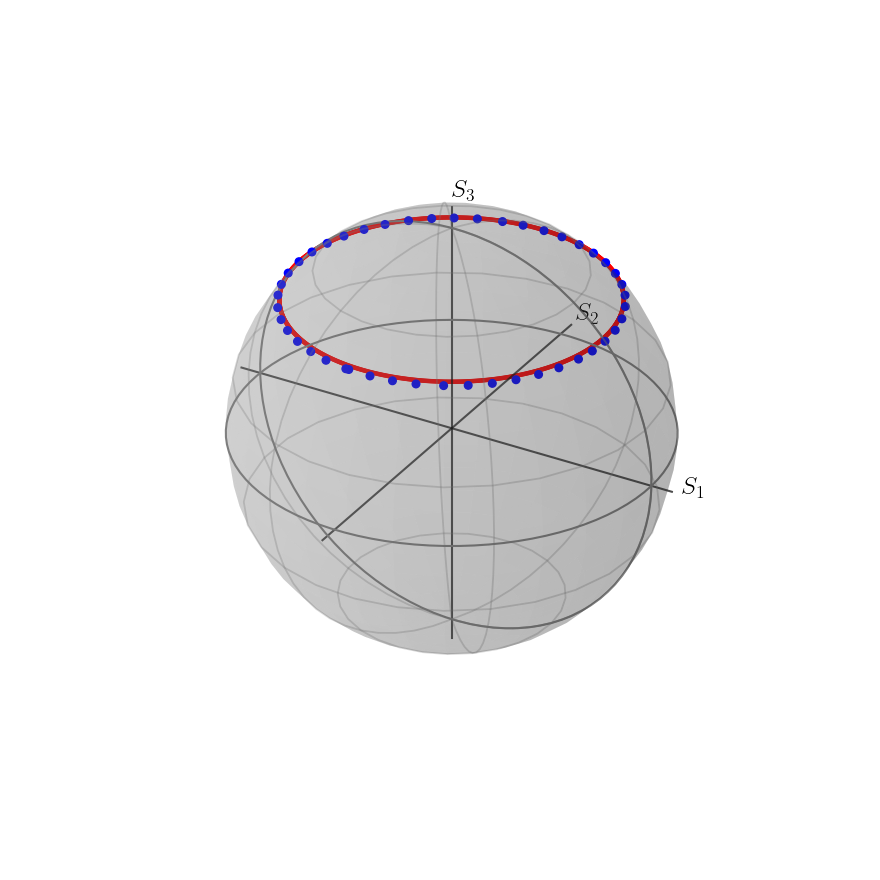

In [7]:
DOP2, S1, S2, S3 = biplate(np.linspace(0,180,1000), -37, Optpathdiff, coherence, (0, state2[0][4]))
Graphic1(S1/DOP2, S2/DOP2, S3/DOP2, 'Data/circular/')

c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  encoding='latin1').mean(axis=None)
c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  encoding='latin1').mean(axis=None)
c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'fram

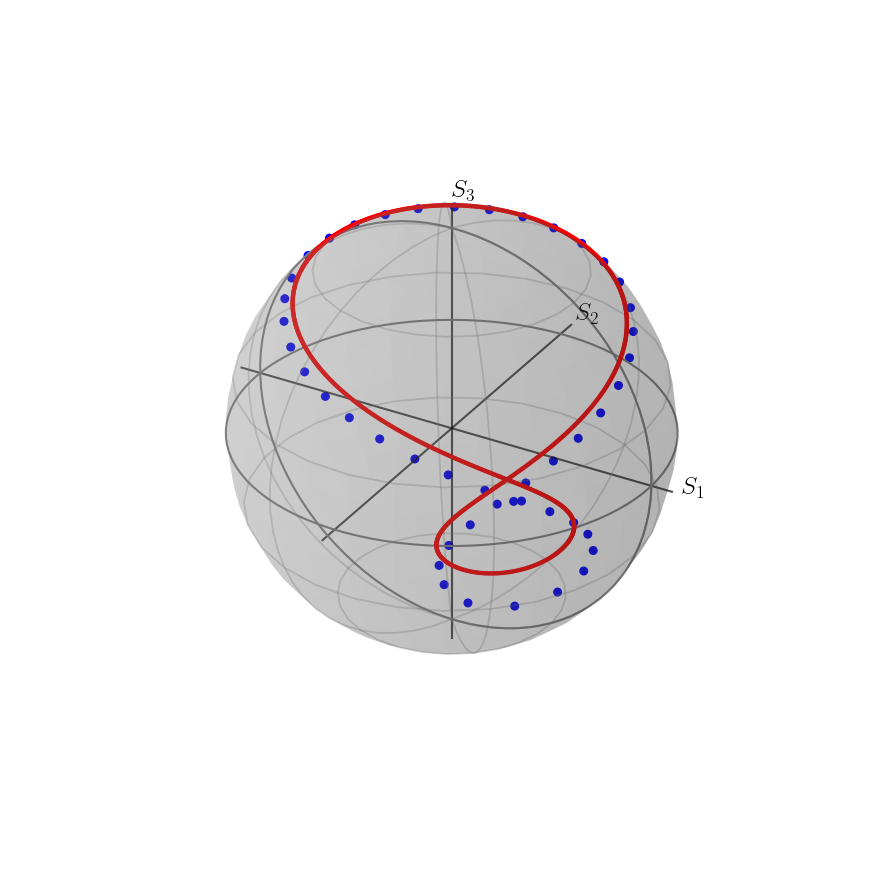

In [8]:
DOP3, S1, S2, S3 = biplate(np.linspace(0,180,1000), -39.6, Optpathdiff, coherence, (27.7, state3[0][4]))
Graphic1(S1/DOP3, S2/DOP3, S3/DOP3, 'Data/elliptical/')

Experimental and theoretical comparison for the Degree of Polarization

In [9]:
exp_data1 = Polarimeter_data(path = 'Data/linear/').mean() #linear
exp_data2 = Polarimeter_data(path = 'Data/circular/').mean() #circular
exp_data3 = Polarimeter_data(path = 'Data/elliptical/').mean() #elliptical

exp_dop1 = exp_data1[:,5]/100 - 0.02
exp_dop2 = exp_data2[:,5]/100 - 0.01
exp_dop3 = exp_data3[:,5]/100

x = np.linspace(0,np.pi,len(exp_dop1))

c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  encoding='latin1').mean(axis=None)
c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  encoding='latin1').mean(axis=None)
c:\Users\crist\Dropbox\Cristian_Hernandez\Artículo Despolarización\Repositorio Experimento\Depolarization_module.py:471: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'fram

Text(0, 0.5, '$Degree$ $of$ $Polarization$')

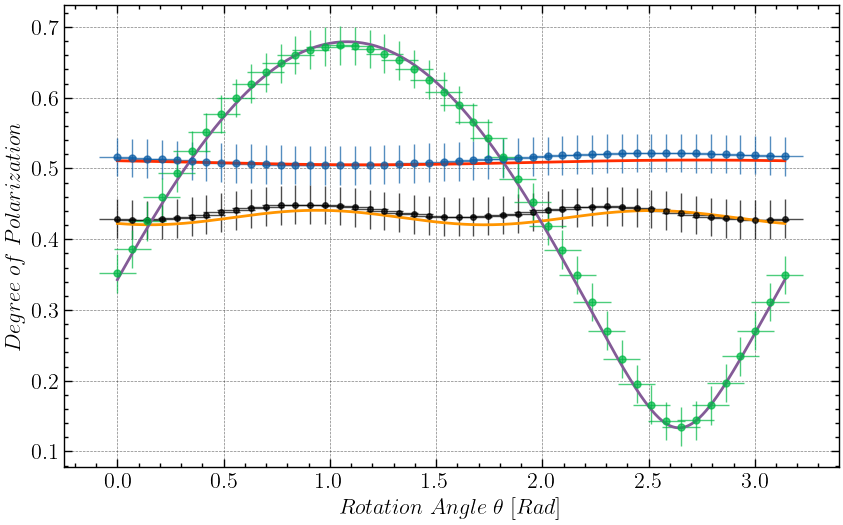

In [10]:
DOP1, S1, S2, S3 = biplate(np.linspace(0,180,1000), phi, Optpathdiff, coherence, (-78, state1[0][4])) #linear
DOP2, S1, S2, S3 = biplate(np.linspace(0,180,1000), -37,  Optpathdiff, coherence, (-60, state2[0][4])) #circular
DOP3, S1, S2, S3 = biplate(np.linspace(0,180,1000), -39.6,  Optpathdiff, coherence, (22, state3[0][4])) #elliptical

DOPerror = 0.02 + Polarimeter_data(path = 'Data/linear/').std().std()
angle_error = np.pi/36

plt.figure(figsize=(10, 6))

plt.errorbar(x, exp_dop1, DOPerror, angle_error, fmt='.k', alpha = 0.7, ms = 8, elinewidth=1)
plt.errorbar(x, exp_dop2, DOPerror , angle_error,'o', alpha = 0.7, ms = 5, elinewidth=1)
plt.errorbar(x, exp_dop3, DOPerror , angle_error,'o', alpha = 0.7, ms = 5, elinewidth=1)

plt.plot(np.linspace(0,np.pi,1000),DOP1)
plt.plot(np.linspace(0,np.pi,1000),DOP2)
plt.plot(np.linspace(0,np.pi,1000),DOP3)

plt.xlabel("$Rotation$ $Angle$ $\\theta$ $[Rad]$")
plt.ylabel("$Degree$ $of$ $Polarization$")



Finally, we can notice in the last graphic that for none of the three incident polarization state there is an angle $\theta$ for which the Degree of Polarization is 1, i.e. it doesn't depolarize. Then we proceed to graphic theoretically the degree of polarization as a function of all the posible incident polarization states:

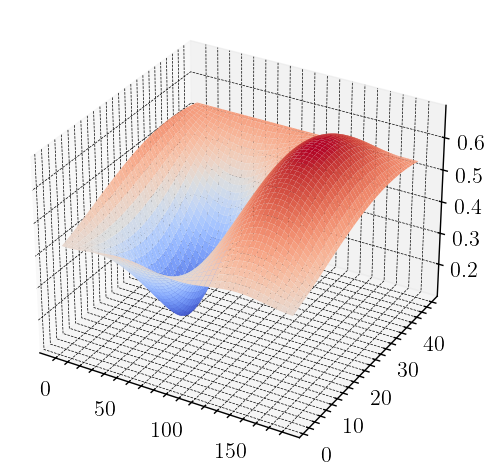

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y = np.meshgrid(np.linspace(0,180,100),np.linspace(0,45,100))
        
fig = plt.figure()
#ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y, biplate( 0, phi, Optpathdiff, coherence, [x,y])[0], cmap=cm.coolwarm, linewidth=2)